In [1]:
%reset
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.ticker as mticker

import warnings; warnings.filterwarnings('ignore')
import cmocean
from xgcm import Grid

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
import matplotlib.colors as colors

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

## Reading in NW2 data:

In [5]:
%cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/nw2_0.03125deg_N15_baseline/
fs_003125 = xr.open_dataset('static.nc', decode_times=False)
av_003125 = xr.open_mfdataset(['averages_00001302.nc', 'averages_00001402.nc'],decode_times=False)

# %cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/nw2_0.03125deg_N15_QG_Leith_v1/
# fs_QGleith1 = xr.open_dataset('static.nc', decode_times=False)
# av_QGleith1 = xr.open_dataset('averages_00000102.nc', decode_times=False)

# %cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/nw2_0.03125deg_N15_QG_Leith_v2/
# fs_QGleith2 = xr.open_dataset('static.nc', decode_times=False)
# av_QGleith2 = xr.open_dataset('averages_00000102.nc', decode_times=False)

%cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/nw2_0.03125deg_N15_QG_Leith_v3/
fs_QGleith3 = xr.open_dataset('static.nc', decode_times=False)
av_QGleith3 = xr.open_mfdataset(['averages_00001302.nc','averages_00001402.nc'], decode_times=False)


%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/

/glade/p/univ/unyu0004/gmarques/NeverWorld2/nw2_0.03125deg_N15_baseline
/glade/scratch/gmarques/NW2_TMP/nw2_0.03125deg_N15_QG_Leith_v3
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [6]:
#Read in various grid variables from the static file:
lon=fs_003125['geolon']; lat=fs_003125['geolat']
depth = np.array(fs_003125['depth_ocean'])
area_t=np.array(fs_003125['area_t'])

xh = fs_003125.xh.values
yh = fs_003125.yh.values
dxh = fs_003125.dxCu.values; dxh = dxh[:,1:] #(dxh[1:,:]+dxh[:-1,:])/2.
dyh = fs_003125.dyCv.values; dyh = dyh[1:,:] #dyh = (dyh[:,1:]+dyh[:,:-1])/2.

#Layer = np.array(os['Layer']);
#drho=np.zeros(15);
#drho[0]=Layer[0]; drho[1:]=np.diff(Layer)
#print(drho); #drho contains the density differences across each interface. 15 entries, includes surface but not bottom.

In [7]:
print(av_QGleith3)

<xarray.Dataset>
Dimensions:              (nv: 2, time: 40, xh: 1920, xq: 1921, yh: 4480, yq: 4481, zi: 16, zl: 15)
Coordinates:
  * xq                   (xq) float64 0.0 0.03125 0.0625 ... 59.94 59.97 60.0
  * yh                   (yh) float64 -69.98 -69.95 -69.92 ... 69.92 69.95 69.98
  * zl                   (zl) float64 1.023e+03 1.023e+03 ... 1.028e+03
  * time                 (time) float64 1.302e+03 1.308e+03 ... 1.498e+03
  * nv                   (nv) float64 1.0 2.0
  * xh                   (xh) float64 0.01562 0.04688 0.07812 ... 59.95 59.98
  * yq                   (yq) float64 -70.0 -69.97 -69.94 ... 69.94 69.97 70.0
  * zi                   (zi) float64 1.022e+03 1.023e+03 ... 1.028e+03
Data variables:
    h_du_dt              (time, zl, yh, xq) float32 dask.array<chunksize=(20, 15, 4480, 1921), meta=np.ndarray>
    h_dv_dt              (time, zl, yq, xh) float32 dask.array<chunksize=(20, 15, 4481, 1920), meta=np.ndarray>
    h_diffu              (time, zl, yh, xq) float32

## Plan view KE budget terms for the Smag run:

In [8]:
KEterm1 = av_003125['dKE_dt'][:,:,:,:].mean('time')
#assuming all of these are on the RHS of the KE equation
KEterm2 = av_003125['KE_CorAdv'][:,:,:,:].mean('time')
KEterm3 = av_003125['PE_to_KE'][:,:,:,:].mean('time')
KEterm4 = av_003125['KE_BT'][:,:,:,:].mean('time')
KEterm5 = av_003125['KE_visc'][:,:,:,:].mean('time')
KEterm6 = av_003125['KE_horvisc'][:,:,:,:].mean('time')
#KE_stress = av['KE_stress'][:,:,:,:]#.mean('time') # Part of KEterm5, corresponds to surface wind stress contribution

#Summing vertically:
KEterm1 = (KEterm1).sum(axis=0);
KEterm2 = (KEterm2).sum(axis=0);
KEterm3 = (KEterm3).sum(axis=0);
KEterm4 = (KEterm4).sum(axis=0);
KEterm5 = (KEterm5).sum(axis=0);
KEterm6 = (KEterm6).sum(axis=0);
#KE_stress = KE_stress.sum(axis=0)

E = KEterm1-KEterm2-KEterm3-KEterm4-KEterm5-KEterm6 #residual term between dKE/dt and RHS of equation



In [12]:
KEterm6.shape

(4480, 1920)

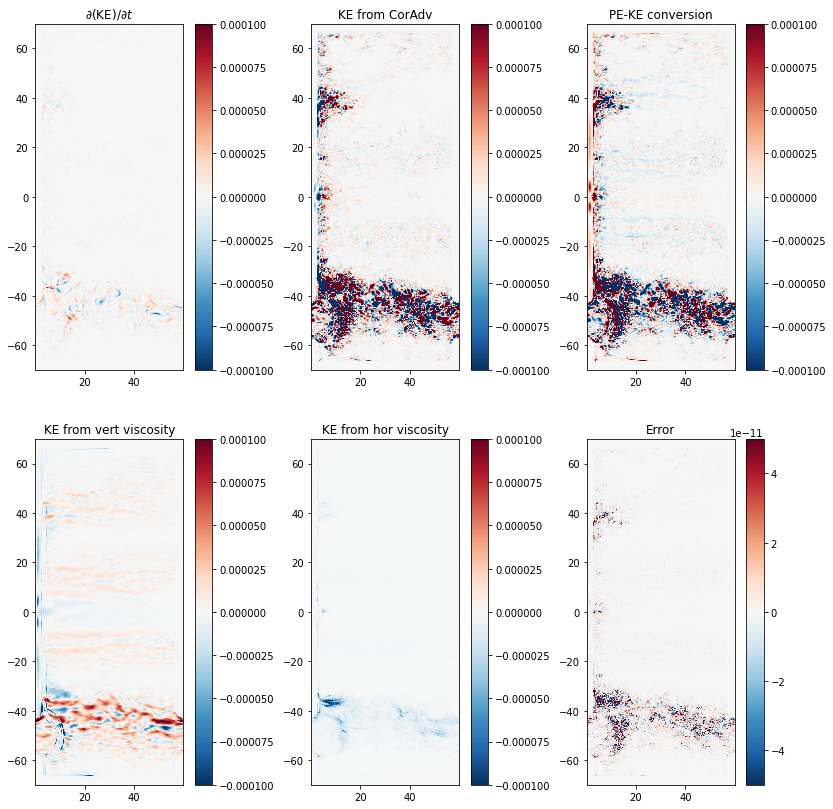

In [13]:
plt.figure(figsize=(14,14))

cmin=-1e-4; cmax=1.e-4;
plt.subplot(2,3,1)
plt.pcolormesh(xh,yh,KEterm1,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$\partial ($KE$)/\partial t$')
plt.colorbar()

plt.subplot(2,3,2)
plt.pcolormesh(xh,yh,KEterm2,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'KE from CorAdv')
plt.colorbar()

plt.subplot(2,3,3)
plt.pcolormesh(xh,yh,(KEterm3+KEterm4),norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'PE-KE conversion')
plt.colorbar()


plt.subplot(2,3,4)
plt.pcolormesh(xh,yh,KEterm5,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'KE from vert viscosity')
plt.colorbar()

plt.subplot(2,3,5)
plt.pcolormesh(xh,yh,KEterm6,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'KE from hor viscosity')
plt.colorbar()

plt.subplot(2,3,6)
plt.pcolormesh(xh,yh,E,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=-5e-11,vmax=5e-11)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'Error')

plt.colorbar()

## Plan view KE budget terms for the QG Leith run:

In [14]:
KEterm1 = av_QGleith3['dKE_dt'][:,:,:,:].mean('time')
#assuming all of these are on the RHS of the KE equation
KEterm2 = av_QGleith3['KE_CorAdv'][:,:,:,:].mean('time')
KEterm3 = av_QGleith3['PE_to_KE'][:,:,:,:].mean('time')
KEterm4 = av_QGleith3['KE_BT'][:,:,:,:].mean('time')
KEterm5 = av_QGleith3['KE_visc'][:,:,:,:].mean('time')
KEterm6 = av_QGleith3['KE_horvisc'][:,:,:,:].mean('time')
#KE_stress = av['KE_stress'][:,:,:,:]#.mean('time') # Part of KEterm5, corresponds to surface wind stress contribution

#Summing vertically:
KEterm1 = (KEterm1).sum(axis=0);
KEterm2 = (KEterm2).sum(axis=0);
KEterm3 = (KEterm3).sum(axis=0);
KEterm4 = (KEterm4).sum(axis=0);
KEterm5 = (KEterm5).sum(axis=0);
KEterm6 = (KEterm6).sum(axis=0);
#KE_stress = KE_stress.sum(axis=0)

E = KEterm1-KEterm2-KEterm3-KEterm4-KEterm5-KEterm6 #residual term between dKE/dt and RHS of equation

print('done')

done


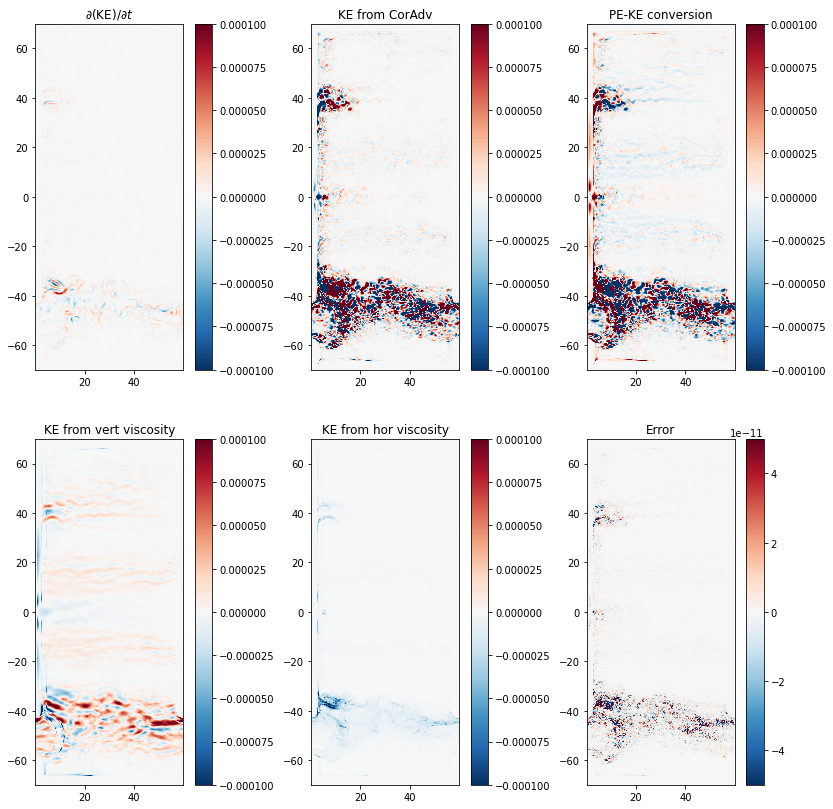

In [15]:
plt.figure(figsize=(14,14))

cmin=-1e-4; cmax=1.e-4;
plt.subplot(2,3,1)
plt.pcolormesh(xh,yh,KEterm1,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$\partial ($KE$)/\partial t$')
plt.colorbar()

plt.subplot(2,3,2)
plt.pcolormesh(xh,yh,KEterm2,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'KE from CorAdv')
plt.colorbar()

plt.subplot(2,3,3)
plt.pcolormesh(xh,yh,(KEterm3+KEterm4),norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'PE-KE conversion')
plt.colorbar()


plt.subplot(2,3,4)
plt.pcolormesh(xh,yh,KEterm5,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'KE from vert viscosity')
plt.colorbar()

plt.subplot(2,3,5)
plt.pcolormesh(xh,yh,KEterm6,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'KE from hor viscosity')
plt.colorbar()

plt.subplot(2,3,6)
plt.pcolormesh(xh,yh,E,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=-5e-11,vmax=5e-11)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'Error')

plt.colorbar()

In [ ]:
# #Within specific regions:

# #0.25 degree: 
# #ACC West is lon:20:80,   lat: 20:140
# #ACC East is lon:160:220, lat: 20:140
# #North    is lon:20:220,  lat: 160:540
# lon1 = 1280; lon2=1760;
# lat1 = 160; lat2=1120;

# KEterm1 = (av['dKE_dt'][:,:,lat1:lat2,lon1:lon2]).sum(axis=1) #summing vertically
# #assuming all of these are on the RHS of the KE equation
# KEterm2 = (av['KE_CorAdv'][:,:,lat1:lat2,lon1:lon2]).sum(axis=1)
# KEterm2_alternate = (av['KE_adv'][:,:,lat1:lat2,lon1:lon2]).sum(axis=1)
# KEterm3 = (av['PE_to_KE'][:,:,lat1:lat2,lon1:lon2]).sum(axis=1)
# KEterm4 = (av['KE_BT'][:,:,lat1:lat2,lon1:lon2]).sum(axis=1)
# KEterm5 = (av['KE_visc'][:,:,lat1:lat2,lon1:lon2]).sum(axis=1)
# KEterm6 = (av['KE_horvisc'][:,:,lat1:lat2,lon1:lon2]).sum(axis=1)
# KE_stress= (av['KE_stress'][:,:,lat1:lat2,lon1:lon2]).sum(axis=1)

# KEterm1 = (KEterm1).mean(axis=0); #time averagin
# KEterm2 = (KEterm2).mean(axis=0);
# KEterm2_alternate = (KEterm2_alternate).mean(axis=0);
# KEterm3 = (KEterm3).mean(axis=0);
# KEterm4 = (KEterm4).mean(axis=0);
# KEterm5 = (KEterm5).mean(axis=0);
# KEterm6 = (KEterm6).mean(axis=0);
# KE_stress= KE_stress.mean(axis=0)

# E = KEterm1-KEterm2-KEterm3-KEterm4-KEterm5-KEterm6 #residual term between dKE/dt and RHS of equation
# E_alternate = KEterm1-KEterm2_alternate-KEterm3-KEterm4-KEterm5-KEterm6
# print(KEterm1.shape,E.shape)


In [21]:
plt.rc('font', size=14)
plt.figure(figsize=(10, 4), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(yh[lat1:lat2],KEterm1.mean(axis=1),'-',c='#117733',linewidth=2)
plt.plot(yh[lat1:lat2],KEterm2.mean(axis=1),'-',c='#44AA99',linewidth=2)
plt.plot(yh[lat1:lat2],(KEterm3+KEterm4).mean(axis=1),'-',c='#999933',linewidth=2)
plt.plot(yh[lat1:lat2],(KE_stress).mean(axis=1),'-',c='#332288',linewidth=2)
plt.plot(yh[lat1:lat2],(KEterm5-KE_stress).mean(axis=1),'-',c='#CC6677',linewidth=2)

plt.plot(yh[lat1:lat2],(KEterm6).mean(axis=1),'-',c='#882255',linewidth=2)
plt.plot(yh[lat1:lat2],E.mean(axis=1),':',c='k',linewidth=2)


plt.grid()

plt.legend(['Time tendency','Advection','Conversion','Wind stress','Vert. dissipation','Hor. dissipation','Residual'],loc='lower right',fontsize=10)
#plt.plot([0, 0],[-100, 100],'--',color=[0,0,0])
plt.xlim(-20,70);# plt.xticks(fontsize=14); 
plt.ylim(-2.5e-5,2.5e-5); 
plt.yticks(fontsize=14)

#plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.xlabel('Latitude',fontsize=14)
plt.ylabel('$m^3/s^3$',fontsize=14)
plt.title('Outside ACC',fontsize=14)




NameError: name 'lat1' is not defined

<Figure size 1000x400 with 0 Axes>

Text(0.5, 1.0, 'Eastern ACC')

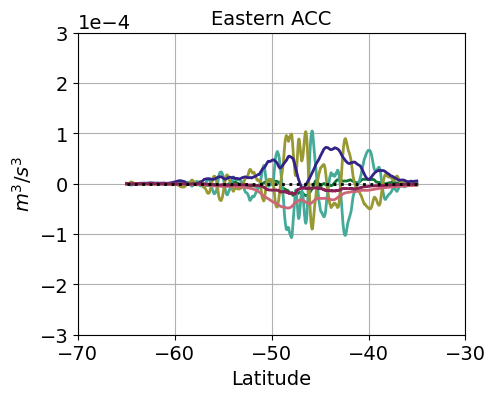

In [49]:
plt.rc('font', size=14)
plt.figure(figsize=(5, 4), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(yh[lat1:lat2],KEterm1.mean(axis=1),'-',c='#117733',linewidth=2)
plt.plot(yh[lat1:lat2],KEterm2.mean(axis=1),'-',c='#44AA99',linewidth=2)
plt.plot(yh[lat1:lat2],(KEterm3+KEterm4).mean(axis=1),'-',c='#999933',linewidth=2)
plt.plot(yh[lat1:lat2],(KE_stress).mean(axis=1),'-',c='#332288',linewidth=2)
plt.plot(yh[lat1:lat2],(KEterm5-KE_stress).mean(axis=1),'-',c='#CC6677',linewidth=2)

plt.plot(yh[lat1:lat2],(KEterm6).mean(axis=1),'-',c='#882255',linewidth=2)
plt.plot(yh[lat1:lat2],E.mean(axis=1),':',c='k',linewidth=2)


plt.grid()

#plt.legend(['Time tendency','Advection','Conversion','Wind stress','Vert. dissipation','Hor. dissipation','Residual'],loc='lower right',fontsize=10)
#plt.plot([0, 0],[-100, 100],'--',color=[0,0,0])
plt.xlim(-70,-30);# plt.xticks(fontsize=14); 
plt.ylim(-3.e-4,3.e-4); 
plt.yticks(fontsize=14)

plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.xlabel('Latitude',fontsize=14)
plt.ylabel('$m^3/s^3$',fontsize=14)
plt.title('Eastern ACC',fontsize=14)


In [24]:
lat2

540

Text(0.5, 1.0, 'Western ACC')

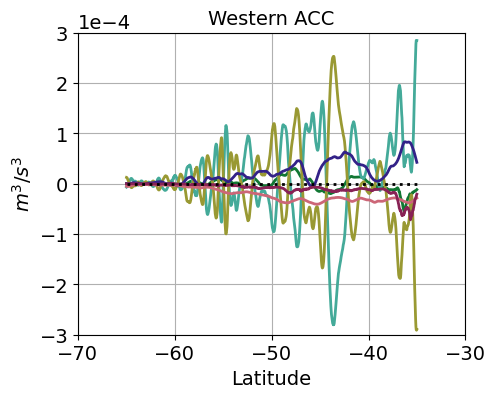

In [47]:
plt.rc('font', size=14)
plt.figure(figsize=(5, 4), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(yh[lat1:lat2],KEterm1.mean(axis=1),'-',c='#117733',linewidth=2)
plt.plot(yh[lat1:lat2],KEterm2.mean(axis=1),'-',c='#44AA99',linewidth=2)
plt.plot(yh[lat1:lat2],(KEterm3+KEterm4).mean(axis=1),'-',c='#999933',linewidth=2)
plt.plot(yh[lat1:lat2],(KE_stress).mean(axis=1),'-',c='#332288',linewidth=2)
plt.plot(yh[lat1:lat2],(KEterm5-KE_stress).mean(axis=1),'-',c='#CC6677',linewidth=2)

plt.plot(yh[lat1:lat2],(KEterm6).mean(axis=1),'-',c='#882255',linewidth=2)
plt.plot(yh[lat1:lat2],E.mean(axis=1),':',c='k',linewidth=2)


plt.grid()

#plt.legend(['Time tendency','Advection','Conversion','Wind stress','Vert. dissipation','Hor. dissipation','Residual'],loc='lower right',fontsize=10)
#plt.plot([0, 0],[-100, 100],'--',color=[0,0,0])
plt.xlim(-70,-30);# plt.xticks(fontsize=14); 
plt.ylim(-3.e-4,3.e-4); 
plt.yticks(fontsize=14)

plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.xlabel('Latitude',fontsize=14)
plt.ylabel('$m^3/s^3$',fontsize=14)
plt.title('Western ACC',fontsize=14)